In [1]:
from ssri_interactions.config import ExperimentInfo, Config
from ssri_interactions.transforms import SpikesHandler
from ssri_interactions.io import load_derived_generic
from ssri_interactions.stats import mannwhitneyu_plusplus
from ssri_interactions.plots import PAL_GREY_BLACK
import numpy as np
import pandas as pd
from scipy.stats import zscore, zmap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# %load_ext rpy2.ipython

# sns.set_theme(context="paper", style="ticks")

#### Utils

In [47]:
def load_drug_data(
    block="chal", 
    t_start=-600, 
    t_stop=1200, 
    bin_width=1,
    sessions=None,
    merge_neuron_types=False,
    group_names=None,
    ):
    df_binned = SpikesHandler(
        block=block,
        bin_width=bin_width,
        session_names=sessions,
        t_start=t_start,
        t_stop=t_stop,
    ).binned
    df_binned["block"] = np.where(df_binned["bin"] < 0, "pre", "post")
    neuron_types = load_derived_generic("neuron_types.csv")[["neuron_id", "neuron_type", "session_name", "group_name"]]
    df_binned = df_binned.merge(neuron_types)
    if group_names is not None:
        df_binned = df_binned.query("group_name in @group_names")
    return df_binned


def mwu(df):
    pre = df.query("block == 'pre'")["zcounts"].values
    post = df.query("block == 'post'")["zcounts"].values
    return mannwhitneyu_plusplus(pre, post, names=("pre", "post"))

def stacked_bar_single(df, col, ax):
    df[col].value_counts().to_frame().T.plot(kind="bar", stacked=True, ax=ax, legend=False)
    ax.axis("off")
    return ax

def get_response(df, sig_col="sig", diff_col="Diff"):
    return np.where(
        df[sig_col] == True, 
        np.where(df[diff_col] > 0, "activated", "inhibited"), 
        "non responder")

# Citalopram

#### Load Data

In [3]:
neuron_types = load_derived_generic("neuron_types.csv")
df_chal =load_drug_data()

#### Preprocess

In [4]:
df_chal = df_chal.groupby("neuron_id").filter(lambda x: x.query("bin < 0").counts.sum() > 250)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_chal["zcounts"] = df_chal.groupby("neuron_id")["counts"].transform(lambda x: zmap(x, x[:600]))

    df_chal = df_chal.dropna()

#### Get Responders (SU)

In [50]:
df_cit_responders = (
    df_chal
    .groupby("neuron_id")
    .apply(mwu)
    .reset_index()
    .merge(neuron_types)
)
df_cit_responders["sig"] = (df_cit_responders["p"] < 0.05) & (df_cit_responders["Diff"].abs() >= 0.2)
df_cit_responders["response"] = get_response(df_cit_responders)

#### Export

In [51]:
data_dir = Config.derived_data_dir
fn_cit_counts = data_dir / "chal_binned.parquet"
fn_cit_responders = data_dir / "chal_responders.csv"

df_chal.to_parquet(fn_cit_counts, index=False)
df_cit_responders.to_csv(fn_cit_responders, index=False)

print("Acute Cit Data:")
print(f"\tData Dir: {data_dir}")
print(f"\tCounts: {fn_cit_counts.name}")
print(f"\tResponders: {fn_cit_responders.name}")

Acute Cit Data:
	Data Dir: /Users/ruairiosullivan/repos/SSRI Interactions/data/derived
	Counts: chal_binned.parquet
	Responders: chal_responders.csv


# Way

#### Load Data

In [7]:
df_way = load_drug_data(block="way")

#### Preprocess

In [52]:
# df_way.groupby("neuron_id").filter(lambda x: x.query("bin < 0").counts.sum() > 50)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_way["zcounts"] = df_way.groupby("neuron_id")["counts"].transform(lambda x: zmap(x, x[:600]))
    df_way = df_way.dropna()

#### Get Responders (SU)

In [53]:
df_responders_way = (
    df_way
    .groupby("neuron_id")
    .apply(mwu)
    .reset_index()
    .merge(neuron_types)
)
df_responders_way["sig"] = (df_responders_way["p"] < 0.05) & (df_responders_way["Diff"].abs() >= 0.2)
df_responders_way["response"] = get_response(df_responders_way)

#### Export

In [54]:
data_dir = Config.derived_data_dir
fn_way_counts = data_dir / "way_binned.parquet"
fn_way_responders = data_dir / "way_responders.csv"

df_way.to_parquet(fn_way_counts, index=False)
df_responders_way.to_csv(fn_way_responders, index=False)

print("Acute Way Data:")
print(f"\tData Dir: {data_dir}")
print(f"\tCounts: {fn_way_counts.name}")
print(f"\tResponders: {fn_way_responders.name}")

Acute Way Data:
	Data Dir: /Users/ruairiosullivan/repos/SSRI Interactions/data/derived
	Counts: way_binned.parquet
	Responders: way_responders.csv


# Plots

In [11]:
from sklearn.preprocessing import minmax_scale

def pivot(df, value_col="zcounts", index="neuron_id", columns="bin", aggfunc="mean"):
    return (
        df
        .pivot_table(index=index, columns=columns, values=value_col, aggfunc=aggfunc)
    )

def sort_by_response(df_piv, df_response, df_response_mag_col="diff", **sort_values_kwargs):
    ordered_responders = (
        df_response
        [["neuron_id", "neuron_type", "group", df_response_mag_col]]
        .set_index("neuron_id")
        .reindex(df_piv.index)
        .sort_values(["neuron_type", df_response_mag_col], **sort_values_kwargs)
        .dropna()
    )
    ordered_piv = df_piv.reindex(ordered_responders.index)
    return ordered_piv, ordered_responders


def plot_heatmap_color(df_piv, ax, cmap="vlag", vmin=-2, vmax=2, **kwargs):
    sns.heatmap(df_piv, cmap=cmap, center=0, robust=True, vmax=vmax, vmin=vmin, cbar=False, ax=ax)
    ax.set_yticks([])
    ax.set_xticks([0, 600, 1200, 1800])
    ax.set_ylabel("")
    ax.set_xlabel("")
    return ax

def plot_heatmap_greyscale(df_piv, ax, **kwargs):
    sns.heatmap(df_piv.transform(minmax_scale, axis=1), cmap="Greys", vmin=0, vmax=1, cbar=False, ax=ax, **kwargs)
    ax.set_yticks([])
    ax.set_xticks([0, 600, 1200, 1800])
    ax.set_ylabel("")
    ax.set_xlabel("")
    return ax

## Citalopram

#### Load Data

In [12]:
# load data
neuron_types = (
    load_derived_generic("neuron_types.csv")
    [["neuron_id", "session_name", "neuron_type", "group"]]
    .query('group in ("SAL", "CIT")')
)
df_chal = pd.read_parquet(fn_cit_counts).merge(neuron_types)
df_cit_responders = pd.read_csv(fn_cit_responders).merge(neuron_types)


#### All Neuron Heats

<AxesSubplot: >

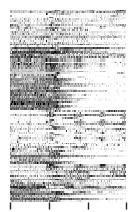

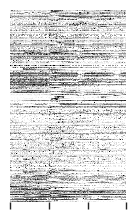

In [13]:

# pivot by group
slow_piv_sal, slow_piv_sal_key = (
    df_chal
    .query("group == 'SAL'")
    .pipe(pivot, value_col="counts")
    .pipe(
        sort_by_response, 
        df_response=df_cit_responders.query("group == 'SAL'"),
        df_response_mag_col="Diff",
        ascending=False
        )
)
slow_piv_cit, slow_piv_cit_key = (
    df_chal
    .query("group == 'CIT'")
    .pipe(pivot, value_col="counts")
    .pipe(
        sort_by_response, 
        df_response=df_cit_responders.query("group == 'CIT'"),
        df_response_mag_col="Diff",
        ascending=False
        )
)

f_sal = plt.figure(figsize=(1.5, 2.5))
ax_sal = f_sal.subplots()
# plot_heatmap_color(slow_piv_sal, ax_sal, vmin=-2, vmax=2)
plot_heatmap_greyscale(slow_piv_sal, ax=ax_sal)

f_cit = plt.figure(figsize=(1.5, 2.5))
ax_cit = f_cit.subplots()
# plot_heatmap_color(slow_piv_cit, ax_cit, vmin=-2, vmax=2)
plot_heatmap_greyscale(slow_piv_cit, ax=ax_cit)

#### Single Session Heats

<AxesSubplot: >

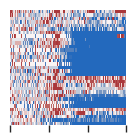

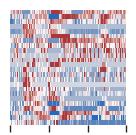

In [14]:
sal_sessions = ExperimentInfo.sal_sessions
cit_sessions = ExperimentInfo.cit_sessions
sal_session = sal_sessions[2]
cit_session = cit_sessions[0]

slow_piv_sal, slow_piv_sal_key = (
    df_chal
    .query("session_name == @sal_session")
    .pipe(pivot)
    .pipe(
        sort_by_response, 
        df_response=df_cit_responders.query("session_name == @sal_session"),
        df_response_mag_col="Diff",
        ascending=False
        )
)
slow_piv_cit, slow_piv_cit_key = (
    df_chal
    .query("session_name == @cit_session")
    .pipe(pivot)
    .pipe(
        sort_by_response, 
        df_response=df_cit_responders.query("session_name == @cit_session"),
        df_response_mag_col="Diff",
        ascending=False
        )
)

f_sal = plt.figure(figsize=(1.5, 1.5))
ax_sal = f_sal.subplots()
plot_heatmap_color(slow_piv_sal, ax_sal, vmin=-2, vmax=2)

f_cit = plt.figure(figsize=(1.5, 1.5))
ax_cit = f_cit.subplots()
plot_heatmap_color(slow_piv_cit, ax_cit, vmin=-2, vmax=2)

#### Prepost Average Lines

/opt/miniconda3/envs/ssri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/ssri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


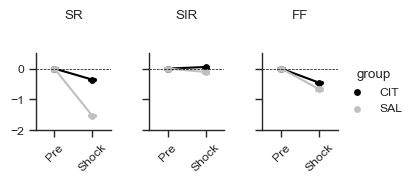

In [21]:
g = sns.catplot(
    x="block", 
    y="zcounts", 
    col="neuron_type",
    hue="group",
    sharey=True,
    sharex=True,
    capsize=0.15, 
    height=1, 
    aspect=1.2, 
    color="black",
    kind="point", 
    data=df_chal,
    scale=0.7,
    facet_kws=dict(gridspec_kws=dict(hspace=0.5, wspace=0.5)),
    palette=PAL_GREY_BLACK,
    hue_order=["CIT", "SAL"],
    col_order=["SR", "SIR", "FF"]
)
g.set_xlabels("")
g.set_ylabels("")
g.set_titles("{col_name}", pad=25)
g.despine()
g.set_xticklabels(["Pre", "Shock"], rotation=45)

for ax in g.axes.flatten():
    ax.axhline(0, color="black", linestyle="--", linewidth=0.5)
    ax.set_ylim(-2, 0.5)

#### Single Neuron Heats

/opt/miniconda3/envs/ssri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/ssri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


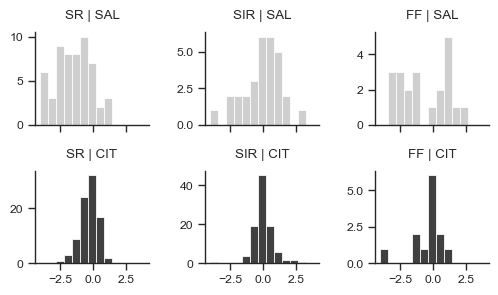

In [45]:
df_cit_responders["Diff_round"] = np.select(
    [df_cit_responders["Diff"] > 4, df_cit_responders["Diff"] < -4],
    [4, -4],
    default=df_cit_responders["Diff"],
    )


g = sns.FacetGrid(

    col="neuron_type",
    row="group",
    sharey=False,
    # sharex=True,
    height=1.5, 
    aspect=1.3, 
    # color="black",
    # kind="point", 
    data=df_cit_responders,
    # scale=0.7,
    gridspec_kws=dict(hspace=0.5, wspace=0.5),
    palette=PAL_GREY_BLACK,
    hue_order=["CIT", "SAL"],
    col_order=["SR", "SIR", "FF"],
    hue="group"
)
g.map_dataframe(sns.histplot, bins=np.arange(-4, 4.1, 0.6), x="Diff_round", )
# g.set_xlabels("")
# g.set_ylabels("")
g.set_titles("{col_name} | {row_name}", pad=10)
g.despine()
for ax in g.axes.flatten():
    ax.set_ylabel("")
    ax.set_xlabel("")

## WAY

#### Load Data

In [134]:
# load data
neuron_types = (
    load_derived_generic("neuron_types.csv")
    [["neuron_id", "session_name", "neuron_type", "group"]]
    .query('group in ("SAL", "CIT")')
)
df_way = pd.read_parquet(fn_way_counts).merge(neuron_types)
df_way_responders = pd.read_csv(fn_way_responders).merge(neuron_types)

#### All Neuron Heat

<AxesSubplot: >

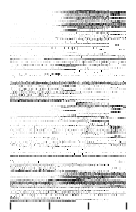

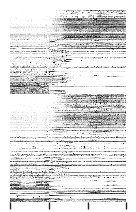

In [135]:
# pivot by group
slow_piv_sal, slow_piv_sal_key = (
    df_way
    .query("group == 'SAL'")
    .pipe(pivot, value_col="counts")
    .pipe(
        sort_by_response, 
        df_response=df_way_responders.query("group == 'SAL'"),
        df_response_mag_col="Diff",
        ascending=False
        )
)
slow_piv_cit, slow_piv_cit_key = (
    df_way
    .query("group == 'CIT'")
    .pipe(pivot, value_col="counts")
    .pipe(
        sort_by_response, 
        df_response=df_way_responders.query("group == 'CIT'"),
        df_response_mag_col="Diff",
        ascending=False
        )
)

f_sal = plt.figure(figsize=(1.5, 2.5))
ax_sal = f_sal.subplots()
# plot_heatmap_color(slow_piv_sal, ax_sal, vmin=-2, vmax=2)
plot_heatmap_greyscale(slow_piv_sal, ax=ax_sal)

f_cit = plt.figure(figsize=(1.5, 2.5))
ax_cit = f_cit.subplots()
# plot_heatmap_color(slow_piv_cit, ax_cit, vmin=-2, vmax=2)
plot_heatmap_greyscale(slow_piv_cit, ax=ax_cit)

/opt/miniconda3/envs/ssri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/ssri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


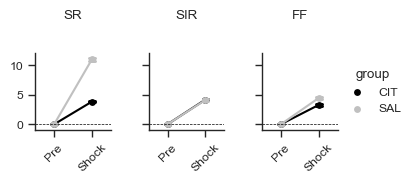

In [138]:
g = sns.catplot(
    x="block", 
    y="zcounts", 
    col="neuron_type",
    hue="group",
    sharey=True,
    sharex=True,
    capsize=0.15, 
    height=1, 
    aspect=1.2, 
    color="black",
    kind="point", 
    data=df_way,
    scale=0.7,
    facet_kws=dict(gridspec_kws=dict(hspace=0.5, wspace=0.5)),
    palette=PAL_GREY_BLACK,
    hue_order=["CIT", "SAL"],
    col_order=["SR", "SIR", "FF"]
)
g.set_xlabels("")
g.set_ylabels("")
g.set_titles("{col_name}", pad=25)
g.despine()
g.set_xticklabels(["Pre", "Shock"], rotation=45)

for ax in g.axes.flatten():
    ax.axhline(0, color="black", linestyle="--", linewidth=0.5)
    ax.set_ylim(-1, 12)